In [1]:
from prelude import *
import pandas as pd

In [2]:
conf = SparkConf().setAppName("question4").setMaster("local[*]")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
lines = sc.textFile('../data/French/2020-02-01')
lines = lines.map(lambda line: json.loads(line))

In [3]:
date_time_begin_str = 'Fri Jan 31 23:00:00 +0000 2020'
date_time_end_str = 'Sat Feb 1 23:30:00 +0000 2020'
date_time_pattern = '%a %b %d %H:%M:%S %z %Y'
target_eta = 5
alpha = 0.99
target_hashtag = 'Brexit'
date_time_begin_obj = datetime.datetime.strptime(
    date_time_begin_str, date_time_pattern)
date_time_end_obj = datetime.datetime.strptime(
    date_time_end_str, date_time_pattern)
delta_time = datetime.timedelta(
     seconds=0,
     minutes=10,
     hours=0,
     days=0,
     )

In [5]:
lines.take(1)

[{'created_at': 'Fri Jan 31 22:59:55 +0000 2020',
  'id': 1223380418189299714,
  'id_str': '1223380418189299714',
  'text': "@Yazidinhok ptdrrrrrrrrr je sais que c'est du cinema fast-food mais bon même pas un sur les 150 000 sortis, c'est abusé",
  'display_text_range': [12, 119],
  'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>',
  'truncated': False,
  'in_reply_to_status_id': 1223379548525531136,
  'in_reply_to_status_id_str': '1223379548525531136',
  'in_reply_to_user_id': 3435541767,
  'in_reply_to_user_id_str': '3435541767',
  'in_reply_to_screen_name': 'Yazidinhok',
  'user': {'id': 1039569053428469760,
   'id_str': '1039569053428469760',
   'name': 'Walid.',
   'screen_name': 'walid_srh',
   'location': 'Paris, France',
   'url': 'https://twitter.com/warriors/status/741477884888391681?s=21',
   'description': '| W.Y | ceux qui manquent sont déjà partis | T.C.O',
   'translator_type': 'none',
   'protected': False,
   'verified': False,
   'fo

In [6]:
def get_time_period(s, time_bucket_size, time_start_at):
    '''
    s: row in RDD
    time_bucket_size: datetiem.timedelta
    time_start_at: datetime.datetime
    '''
    curr_datetime = datetime.datetime.strptime(
        s['created_at'], date_time_pattern)
    date_time_time_period = ((curr_datetime - time_start_at)//time_bucket_size) * time_bucket_size + time_start_at
    date_time_time_period_str = date_time_time_period.strftime('%Y-%m-%d %H:%M:%S')
    return (date_time_time_period_str, 1)
    
    
def filter_hashtag(s, target_hashtag):
    hashtags = list(map(lambda h: h['text'], s['entities']['hashtags']))
    return target_hashtag in hashtags

In [7]:
tweet_with_hashtag = lines.filter(lambda s: filter_hashtag(s, target_hashtag))

In [8]:
hashtag_trend = tweet_with_hashtag.map(lambda s: get_time_period(s, delta_time, date_time_begin_obj)).reduceByKey(lambda a,b:a+b)

In [9]:
hashtag_trend.take(10)

[('2020-01-31 23:30:00', 2),
 ('2020-02-01 01:50:00', 1),
 ('2020-02-01 05:30:00', 1),
 ('2020-02-01 15:00:00', 3),
 ('2020-02-01 16:50:00', 1),
 ('2020-02-01 07:10:00', 2),
 ('2020-02-01 08:10:00', 1),
 ('2020-02-01 12:40:00', 1),
 ('2020-02-01 13:10:00', 1),
 ('2020-02-01 17:40:00', 3)]

In [10]:
hashtag_trend_df = spark.createDataFrame(hashtag_trend,schema=['t', 'hashtag_count']).toPandas()

In [11]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
hashtag_trend_df['t'] = pd.to_datetime(hashtag_trend_df['t'])
hashtag_trend_df = hashtag_trend_df.set_index('t')

In [12]:
hashtag_trend_df

,hashtag_count
t,
2020-01-31 23:30:00,2
2020-02-01 01:50:00,1
2020-02-01 05:30:00,1
2020-02-01 15:00:00,3
2020-02-01 16:50:00,1
...,...
2020-02-01 00:40:00,3
2020-02-01 05:10:00,1
2020-02-01 06:30:00,1


In [13]:
from pandas.tseries.offsets import DateOffset
time_index = pd.date_range(start=date_time_begin_obj, end=date_time_end_obj, freq = delta_time, name='t').strftime('%Y-%m-%d %H:%M:%S')
full_time_index_df = pd.DataFrame(index = time_index)

In [15]:
hashtag_trend_df = full_time_index_df.join(hashtag_trend_df).fillna(0).reset_index()

In [16]:
hashtag_trend_df

,t,hashtag_count
0,2020-01-31 23:00:00,7.0
1,2020-01-31 23:10:00,7.0
2,2020-01-31 23:20:00,2.0
3,2020-01-31 23:30:00,2.0
4,2020-01-31 23:40:00,7.0
...,...,...
143,2020-02-01 22:50:00,0.0
144,2020-02-01 23:00:00,0.0
145,2020-02-01 23:10:00,0.0
146,2020-02-01 23:20:00,0.0


In [17]:
hashtag_trend_df['eta'] = 0.

In [23]:
import scipy.stats.distributions as dists
def get_eta(row):
    # inspired by the code https://github.com/twitterdev/Gnip-Trend-Detection/blob/master/gnip_trend_detection/models.py
    index = row.name
    if index == 0:
        return 0
    else:
        last_count = hashtag_trend_df.loc[index-1].hashtag_count
        
    current_count = row.hashtag_count

    if last_count == 0 or current_count == 0:
        return 0

    Delta_r = abs(current_count - last_count) 
    sensitivity = float(Delta_r)/last_count 
    delta_r = dists.poisson.interval(alpha,last_count)[1] - dists.poisson.interval(alpha,last_count)[0]
    relative_confidence_interval = delta_r/last_count
    return sensitivity/relative_confidence_interval

hashtag_trend_df['eta'] = hashtag_trend_df.apply(get_eta, axis=1)

In [19]:
dists.poisson.interval(0.99,100)

(75.0, 127.0)

In [20]:
hashtag_trend_df = hashtag_trend_df.set_index('t')
hashtag_trend_df

,hashtag_count,eta
t,,
2020-01-31 23:00:00,7.0,0.000000
2020-01-31 23:10:00,7.0,0.000000
2020-01-31 23:20:00,2.0,0.357143
2020-01-31 23:30:00,2.0,0.000000
2020-01-31 23:40:00,7.0,0.833333
...,...,...
2020-02-01 22:50:00,0.0,0.000000
2020-02-01 23:00:00,0.0,0.000000
2020-02-01 23:10:00,0.0,0.000000


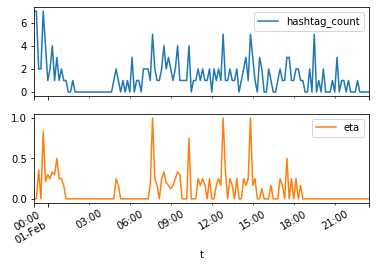

In [21]:
axes = hashtag_trend_df.plot.line(subplots=True)